# **Puddle World**

In this guide, we provide a step-by-step walkthrough on preparing the Puddle World environment for the Competition.

Firstly, we cover the installation of the environment and related dependencies, both for local setup and utilization within a Colab notebook.

Next, we detail the process of initializing the environment with desired configurations and demonstrate how to visualize its characteristics. The goal of the competition is to design an agent that does well in the five provided configurations. Therefore, we show you how to load all the various versions of the environment and inspect their characteristics.

Given the objective of designing a competent agent, we present suggestions for deploying random, human, or untuned DQN agents within the environment. Observing all these different baseline behaviors serves as a valuable starting point for your work.

Finally, it's time to design and train a single agent capable of superior performance across the five configurations of the environment. Testing the agent on these configurations, with the first being the default environment as described in the paper, is crucial. We provide instructions on saving results in a CSV file for submission, marking the beginning of your journey.

Whether you're new to the field and eager to explore or an experienced practitioner aiming to refine your skills, this competition provides a platform to utilize your knowledge and creativity!

# 1. Installing the Requirements

In this section, you can find the necessary information for installing the environment and relavant libraries for your work.

# 2. Introduction to the Environment

The "Puddle World" environment provides an interface for reinforcement learning experiments. It features puddles and challenges agents to navigate to specified goal positions while avoiding the puddles with larger negative rewards.
You can access key details like starting position, goal location, and action noise levels. By printing these attributes, you can gain insights into the environment's layout and develop strategies for training reinforcement learning algorithms effectively within the Puddle World domain.
Here is the default Puddle World configuration inspired by the [original paper](/http://incompleteideas.net/papers/sutton-96.pdf):

**Actions**

There are four actions: up, down, right, and left.
Each action moves approximately 0.05 in these directions. For the case where an action would take the agent out of the screen limits, the action does not move the agent instead.

A random gaussian noise with standard deviation 0.01 is also added to the motion along both dimensions.

**Reward**

The reward is -1 for each time step, plus some additional penalty if the agent gets into the puddle.
The penalty is -400 times the distance into the puddle (distance to the nearest edge).


**Puddle Positions**

The puddles's top-left position is [0.  , 0.85] and [0.35, 0.9] respectively, and the width and height for them is [0.55, 0.2 ] and [0.2, 0.6].

**Start Position**

The agent starts each episode at [0.2, 0.4].

**Goal Position**

The episode ends succesfully if the agent reaches [1.0, 1.0] which is the goal position.


In [2]:
import gymnasium as gym
import gym_puddle

from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy as DQNPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
import pyvirtualdisplay
import cv2

Here are the printed details about the environment.

In [3]:
  env = gym.make("PuddleWorld-v0")

  print("start position:", env.get_wrapper_attr("start"))
  print("goal position:", env.get_wrapper_attr("goal"))
  print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
  print("action noise:", env.get_wrapper_attr("noise"))
  print("agent's thrust:", env.get_wrapper_attr("thrust"))
  print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
  print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
  print("action space:", env.get_wrapper_attr("actions"))
  print("observation space:", env.get_wrapper_attr("observation_space"))

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0.01
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0.0, 1.0, (2,), float64)


Here is the visualization of the environment for the default configuration.

In [4]:
#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
  #Prepares display for onine rendering of the frames in the game
  _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
  _ = _display.start()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1


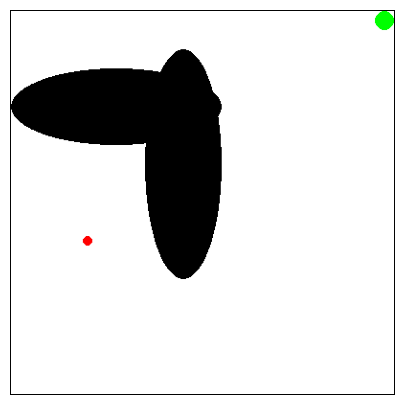

In [7]:
obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(image)

Note: In the subsequent sections of this document, we have used the `prepare_display()` function, which starts a virtual display to show the online rendering of the frames of the game. This function is needed if you want to run the code on Colab, since Colab does not natively support virtual displays.

However, if you are running your code on Windows, you don’t need this function. Instead, you can just rely on the `visualize()` function, which takes the list of frames as input and produces a video of the agent's performance in the game. Another way to visualize on Windows or Mac (or any system supporting virtual display windows) is to set the rendering mode to “human” at the beginning so that a window opens as the game starts and shows the online rendering.

Here is an snippet of how you can do this:

In [5]:
env = gym.make("PuddleWorld-v0", render_mode="human") # you should set the render_mode to "human" to visualize the environment locally. If you are running this code snippet on colab, these lines won't work since colab doesn't support virtual display screens
env.reset() #reset the environment to start a new episode
env.render() #this will open a window to visualize the environment
time.sleep(5) #wait for 5 seconds so that you can see the window
env.close() #you should close the environment to close the virtual window at the end of your code

/Users/siddhartha/Mac Desktop/AMII Hackathon/2024-upper-bound-ai-comp-1/myenv/lib/python3.10/site-packages/gymnasium/envs/registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='human' that is not in the possible render_modes ([]).
  logger.warn(


## 2.1 Accessing Different Environment Configurations

Your task is to train an agent that can generalize well across different provided configurations of the environment. Each of these configurations feature different positions for puddles, which makes it challenging for the agent to find the most rewarding path to the goal.


You can find these configurations in the `env_configs` folder of the repository. In order to access each version of the environment, you can provide the `.json` file indicating the environment details, and intitialize the puddle world as follows:
(Note that if you are using colab, you should upload the configs to the files section of the colab)
The puddle positions are different in these configurations, but other aspects of the environment remain the same.

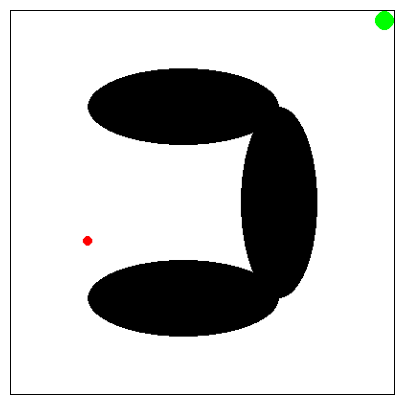

In [7]:
json_file = f"gym_puddle/env_configs/pw4.json"

with open(json_file) as f:
  env_setup = json.load(f)

env = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)

obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(image)

# 3. Developing the Agents

In preparation for the competition, we dive into the exploration of the RL framework through the introduction of three distinct agent types: random, human, and Deep Q-Network (DQN) agents.

Each agent represents varying levels of sophistication and learning abilities within the Puddle World environment. This comprehensive investigation allows us to gain valuable insights into key aspects of the environment as well as exploring RL-related methods such as the utilization of deep reinforcement learning strategies, and related libraries.

Through this exploration, you can familiarize yourself with the environment, grasp the details of the training loop, and become proficient in utilizing essential libraries such as Stable Baselines. This could be a starting point for building your own agent, either using existing libraries, and modifying them to your desires, or implementing new ideas from cutting-edge RL research!

## 3.1. Random Agent


In this section, a "random agent" is deployed to interact with the Puddle World environment. The environment is initialized and visualized, providing a starting point for the agent to explore the world. The random agent **selects actions randomly from the action space and applies them to the environment**. This process is repeated for a predetermined number of time steps (in this case, 10 steps). After each step, the agent's reward is accumulated, and the interaction is visualized through rendering the environment. Finally, the total reward earned in the total time steps is displayed, and the sequence of frames captured during the interaction is saved as a video for further analysis. This random agent serves as a baseline for you to see how the environment works and prepare for the performance of more sophisticated reinforcement learning algorithms in the Puddle World environment.

In [8]:
#prepare_display() #uncomment this line to see the online rendering of the environment frame by frame

env = gym.make("PuddleWorld-v0")

obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []

for time_step in range(10):
    action = env.action_space.sample()  # take a random action
    obs, reward, done, trunc, info = env.step(action)
    total_reward += reward

    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {obs}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "random.mp4")


 t: 0, observation: [0.14759479 0.40156839], reward: -1
 t: 1, observation: [0.15632535 0.46362078], reward: -1
 t: 2, observation: [0.09555847 0.46624159], reward: -1
 t: 3, observation: [0.10704538 0.49764418], reward: -1
 t: 4, observation: [0.11136758 0.44899226], reward: -1
 t: 5, observation: [0.15576357 0.46513777], reward: -1
 t: 6, observation: [0.23715241 0.46112585], reward: -1
 t: 7, observation: [0.15839042 0.45203164], reward: -1
 t: 8, observation: [0.21273543 0.45013314], reward: -1
 t: 9, observation: [0.16956376 0.43695851], reward: -1
no episode finished in this run.


## 3.2. Human Agent

In this section, a "Human Agent" is introduced to interact with the Puddle World environment. The environment is initialized and visualized to provide a starting point for the human agent's interaction. Unlike the random agent, the human agent inputs actions directly from you. You are prompted to enter actions through the command line interface, allowing for real-time interaction. The key mapping is as follows:

w: up
a: left
s: down
d: right

The agent's chosen actions are applied to the environment, and the resulting observations and rewards are displayed. This process is repeated for a predetermined number of time steps (in this case, 10 steps). After each step, the interaction is visualized through rendering the environment. The total reward earned in the total time steps is displayed, and the sequence of frames captured during the interaction is saved as a video for more analysis. This human agent setup enables you to actively engage with the environment and assess its dynamics and challenges from a human perspective.

In [27]:
#prepare_display() #uncomment this line to see the online rendering of the environment frame by frame
env = gym.make("PuddleWorld-v0")

obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []

for time_step in range(10):
    action = get_action()
    obs, reward, done, trunc, info = env.step(action)
    total_reward += reward

    image = env.render()
    # online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {obs}, reward: {reward}")  #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "human.mp4")


 t: 0, observation: [0.19414252 0.47274041], reward: -1
 t: 1, observation: [0.20488488 0.53600763], reward: -1
 t: 2, observation: [0.20399897 0.57971002], reward: -1
 t: 3, observation: [0.19892985 0.62077017], reward: -1
 t: 4, observation: [0.27105588 0.6227926 ], reward: -1
 t: 5, observation: [0.31531393 0.63265628], reward: -1
 t: 6, observation: [0.35289632 0.61945061], reward: -127.78024318597483
 t: 7, observation: [0.42482338 0.63323333], reward: -133.29333065273659


## 3.3. DQN Agent

In this section, a  [ Deep Q-Network (DQN) agent](https://arxiv.org/abs/1312.5602) is utilized to interact with the Puddle World environment. The code demonstrates how to set up training with [Stable Baselines](https://stable-baselines3.readthedocs.io/en/master/), a popular library for reinforcement learning. The DQN model is initialized and trained using default hyperparameters, but you can explore and adjust these hyperparameters for optimal performance. After training, the trained model is loaded for evaluation. The environment is initialized, and the DQN agent's interaction with the environment is visualized. The agent selects actions based on the learned policy, and the environment responds accordingly. This process continues until the episode terminates. At the end of the episode, the total reward earned by the agent is displayed, and the sequence of frames captured during the interaction is saved as a video for further analysis. While the provided code serves as a starting point for training a DQN agent with stable baselines if you wish to use this library, you are encouraged to experiment with different hyperparameters to improve the agent's performance in navigating the complex dynamics of the Puddle World environment. We encourage you to explore more algorithms in the same library or build your agents from scratch.

In [9]:
#train the model, and save the trained model
env = gym.make("PuddleWorld-v0")
dqn_model = DQN(DQNPolicy, env, verbose=1)
dqn_model.learn(total_timesteps=int(1e5))
dqn_model.save("dqn_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 956       |
|    ep_rew_mean      | -8.11e+03 |
|    exploration_rate | 0.637     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 3082      |
|    time_elapsed     | 1         |
|    total_timesteps  | 3823      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 17.7      |
|    n_updates        | 930       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 930       |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.293     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 2876      |
|    time_elapsed     | 2         |
|    total_timesteps  | 7443      |
| trai

In [11]:
dqn_model = DQN.load("dqn_model")
env = gym.make("PuddleWorld-v0")

obs, info = env.reset()

# Create an empty list to store the frames
frames = []
episode_rewards = []

for episode in range(1):
  total_reward = 0
  done = False
  num_steps = 0

  while not done and num_steps <=1000: # to avoid infinite loops for the untuned DQN we set a truncation limit, but you should make your agent sophisticated enough to avoid infinite-step episodes
      num_steps +=1
      action, _states = dqn_model.predict(obs)
      obs, reward, done, trunc, info = env.step(action)
      total_reward += reward
      if done == True:
        print("here")

      image = env.render()
      frames.append(image)

      if done:
        print(f"total reward in this episode: {total_reward}")
        episode_rewards.append(total_reward)
        total_reward = 0
        break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "DQN.mp4")


no episode finished in this run.


#4. Now It's Your Turn!

Now, you're invited to dive into the world of reinforcement learning and take control of the Puddle World environment. We encourage you to become an active participant by modifying the provided code, tweaking parameters, and experimenting with different strategies. You can come up with your own agent ideas, or use pre-exisiting libraries, and adapt them to the problem.


The goal is to build **a single agent that can generalize well across all the environment configurations.**
Once you have built your agent, test your trained agent with 100 different seeds, each seed for one episode, in the five provided configurations, save the total reward in each episode for each configuration, and submit the results as a `.csv` file as indicated in the Kaggle platform. You can set different seeds for the environment with `env.reset(seed = n)`) with `n` being the number from 1 to 100.

 Whether you're a beginner eager to explore or an experienced practitioner seeking to refine your skills, this competition offers an opportunity to apply your knowledge and creativity.



## 4.1. Submission Format

Here you can find a sample submission. Imagine that you have the episodic rewards saved in a list as shown in the below code. You can make a `submission.csv` file with the provided format as follows.

In [12]:
import pandas as pd

# Assuming you have a list of 100 episodic rewards for each configuration
# Example data structure: [(config1_rewards), (config2_rewards), ...]

# Replace this example data with your actual rewards data
episode_rewards_per_configuration = [
     range(-120, -20),  # Configuration 1 rewards
    range(-120, -20),   # Configuration 2 rewards
    range(-120, -20),  # Configuration 3 rewards
    range(-120, -20),  # Configuration 4 rewards
   range(-120, -20),   # Configuration 5 rewards
]

# Define the column names
columns = ['seed_ID', 'ep_reward_pw1', 'ep_reward_pw2', 'ep_reward_pw3', 'ep_reward_pw4', 'ep_reward_pw5']

# Create a list of dictionaries to store data
data = []

# Populate the list with episode IDs and rewards
for episode_id in range(1, 101):  # Assuming 100 episodes
    row_data = {'seed_ID': episode_id}
    for i, rewards in enumerate(episode_rewards_per_configuration):
        row_data[columns[i + 1]] = rewards[episode_id - 1]
    data.append(row_data)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Define the file name for saving the results
csv_file_name = "submission.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)

print("Results saved successfully to", csv_file_name)


Results saved successfully to submission.csv


In [67]:
import pandas as pd

# Define the file name for loading the results
csv_file_name = "submission.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_name)

# Display the DataFrame
print(df)

    seed_ID  ep_reward_pw1  ep_reward_pw2  ep_reward_pw3  ep_reward_pw4  \
0         1           -120           -120           -120           -120   
1         2           -119           -119           -119           -119   
2         3           -118           -118           -118           -118   
3         4           -117           -117           -117           -117   
4         5           -116           -116           -116           -116   
..      ...            ...            ...            ...            ...   
95       96            -25            -25            -25            -25   
96       97            -24            -24            -24            -24   
97       98            -23            -23            -23            -23   
98       99            -22            -22            -22            -22   
99      100            -21            -21            -21            -21   

    ep_reward_pw5  
0            -120  
1            -119  
2            -118  
3            -117  

# 6. Fun Expedition

You can also modify the properties of the environment such as the initial state, puddle locations, and more. You can play around with the environment and challenge your agent to tackle the hardest versions of this environment!

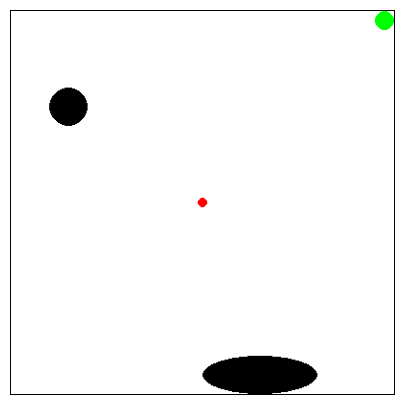

In [14]:
env = gym.make(
        "PuddleWorld-v0",
        start=[0.5,0.5],
        goal=[1.,1.],
        goal_threshold=0.1,
        noise=0.01,
        thrust=0.05,
        puddle_top_left=[[0.1  , 0.8],[0.5, 0.1 ]],
        puddle_width=[[0.1, 0.1 ],[0.3, 0.1]]
    )

obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(image)
